In [30]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from numpy import asarray
from numpy import percentile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

In [2]:
# This class is used for personal and other dataset
class MySpritClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = X[column_name].str.strip()
        return X

# This class is used for other dataset    
class MyAdjustClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['marital-status'] = X['marital-status'].replace('??', np.nan)
        X['occupation'] = X['occupation'].replace('?', np.nan)
        X['pregnant'] = X['pregnant'].replace(['f', 'F', 'FALSE'], 'False')
        X['pregnant'] = X['pregnant'].replace(['t', 'T', 'TRUE'], 'True')
        X['relationship'] = X['relationship'].replace('Not_in_family', 'Not-in-family')
        X['relationship'] = X['relationship'].replace('Own_child', 'Own-child')
        X['relationship'] = X['relationship'].replace('Other_relative', 'Other-relative')
        X['native-country'] = X['native-country'].replace('?', np.nan)
        X['workclass'] = X['workclass'].replace('?', np.nan)
        
        return X

# This class is used for other dataset
class SeparateAndDeleteMedicalInfo(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_medical_info(X)
        return X
    
    def separate_and_delete_medical_info(self, dataframe):
        df2 = pd.DataFrame() 
        # Iterate through every row and take values from medical_info column
        for _,column_data in dataframe['medical_info'].iteritems(): 
            if isinstance(column_data, str): # If value isn't nan
                column_data = column_data[1:-1] # Delect curly brackets from start and end of string
                column_data_split = column_data.split(',') # Split string by comma

                row = {} 
                for name_value in column_data_split: # Iterate through split string
                    name_value_split = name_value.split(':') # Split into name of column and value of column
                    # Store value into dictionary with name of the column as a key
                    row[name_value_split[0][1:-1]] = [np.float(name_value_split[1][1:-1])] # Get rid of '' by [1:-1]

                row_data_frame = pd.DataFrame(row) # Convert dictionary into DataFrame
                df2 = df2.append(row_data_frame, ignore_index=True) # Append row_data_frame into df2
            else: # Value is nan, append nan row into df2
                df2 = df2.append(pd.Series(np.nan), ignore_index=True)

        df2 = df2.drop(columns=[0]) # Drop last column

        # Add values from df2 to main df
        for column_name in df2.columns:
            dataframe[column_name] = df2[column_name]

        del dataframe['medical_info'] # medical info is already divided into another columns, so we can erase it

        return dataframe

# This class is used for personal dataset
class SeparateAndDeleteAddress(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_address(X)
        return X
    
    def separate_and_delete_address(self, dataframe):
        df_addresses = dataframe['address'].replace('\r', ',', regex=True)
        df_addresses = df_addresses.replace('\n', ' ', regex=True)
        df_addresses = df_addresses.str.split(',')

        cities = []
        streets = []
        zip_codes = []

        for address in df_addresses:
            if len(address) < 3: # these records have cities in address
                streets.append(address[0])
                cities.append(None)
                zip_codes.append(address[1])
            else: # these records don't have cities in address
                streets.append(address[0])
                cities.append(address[1])
                zip_codes.append(address[2])

        dataframe['street'] = streets
        dataframe['city'] = cities
        dataframe['zip_code'] = zip_codes

        dataframe = dataframe.drop('address', axis=1)

        return dataframe
    
# This class is used for joined dataset    
class DropDuplicates(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.drop_duplicates(X)
        return X
    
    def drop_duplicates(self, data_frame):
        df1 = data_frame[data_frame.duplicated('name', keep=False)].sort_values('name')

        names = df1['name'].unique() # Get all unique names from duplicates

        # Check odd duplicates
        for name in names:
            number_of_duplicates = df1[df1['name'] == name]
            # Get Odd duplicates
            if len(number_of_duplicates) % 2 != 0:
                # Odd duplicates have different loop, that the even ones.
                for i in range(1, len(number_of_duplicates)): # We start from index one, each iteration we one index back a check NaNs
                    for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i - 1].iteritems()):
                        if pd.isnull(column_data1):
                            data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                        else:
                            data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1
                # From df1 dataset we drop solved odd duplicates
                df1.drop(df1[df1['name'] == 'Joseph Dehaven'].index, inplace = True)

        # Solve even duplicates
        for i in range(0,len(df1.index),2):
            for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i + 1].iteritems()):
                if pd.isnull(column_data1):
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                else:
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1

        data_frame = data_frame.drop_duplicates()

        return data_frame
    
# This class is used for joined dataset    
class ExtractYear(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.extract_year(X)
        return X
    
    def extract_year(self, data_frame):
        years = []
        for cell in data_frame['date_of_birth']:
            if re.match('^[0-9]{2}\-[0-9]{2}\-[0-9]{2}$', cell):
                year = cell[:2]
                years.append(int('19' + year))
            elif re.match('[0-9]{4}', cell):
                years.append(int(re.findall('[0-9]{4}', cell)[0]))
            elif re.match('^[0-9]{2}\/[0-9]{2}\/[0-9]{4}$', cell):
                years.append(int(cell[-4:]))

        data_frame['year_of_birth'] = years

        return data_frame.drop(columns=['date_of_birth'])
    
# This class is used for joined dataset    
class CalculateAgeFromYear(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.calculate_age_from_year(X)
        return X
    
    def calculate_age_from_year(self, data_frame):
        df = data_frame.dropna()
        # Calculate year, when data was recorder
        recording_year = df.iloc[0]['year_of_birth'] + df.iloc[0]['age'] 
        
        new_age = []
        for (age, data1), (year, data2) in zip(data_frame['age'].iteritems(), data_frame['year_of_birth'].iteritems()):
            if pd.isnull(data1):
                new_age.append(recording_year - data2) # There used to be 2020
            else:
                new_age.append(data1)

        data_frame['age'] = new_age

        return data_frame
    
# This class is used for joined dataset    
class GetNumberFromZipCodeDropCityStreet(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.get_number_from_zip_code(X)
        X = X.drop('city', axis=1)
        X = X.drop('street', axis=1)
        return X
    
    def get_number_from_zip_code(self, dataframe):
        zip_numbers = []
        for zip_code in dataframe['zip_code']:
            zip_numbers.append(int(re.findall('[0-9]{4}', zip_code)[0]))

        dataframe['zip_code'] = zip_numbers
        
        return dataframe  

## Načítanie a úprava other datasetov

In [3]:
# other_train
df_other_train = pd.read_csv('./other_train.csv', sep=',', index_col=0) # First column is Unnamed
df_other_valid = pd.read_csv('./other_valid.csv', sep=',', index_col=0)

other_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Adjust', MyAdjustClass()),
    ('Separate and delete medical info', SeparateAndDeleteMedicalInfo())
])

df_other_train = other_pipe.transform(df_other_train)
df_other_valid = other_pipe.transform(df_other_valid)

## Načítanie a úprava personal datasetov

In [4]:
# personal_train
df_personal_train = pd.read_csv("./personal_train.csv", index_col=0, sep=',') # First column was Unnamend
df_personal_valid = pd.read_csv("./personal_valid.csv", index_col=0, sep=',')

personal_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Separate and delete address', SeparateAndDeleteAddress())
])

df_personal_train = personal_pipe.transform(df_personal_train)
df_personal_valid = personal_pipe.transform(df_personal_valid)

## Spojenie train datasetov

In [5]:
df_train_joined = df_other_train.merge(df_personal_train, on='name', how='left') # join other train and personal train on name
del df_train_joined['capital-gain']
del df_train_joined['capital-loss']
del df_train_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

## Spojenie valid datastov

In [6]:
df_valid_joined = df_other_valid.merge(df_personal_valid, on='name', how='left') # join other train and personal train on name
del df_valid_joined['capital-gain']
del df_valid_joined['capital-loss']
del df_valid_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

In [7]:
df_train_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   race              3971 non-null   object 
 2   marital-status    3570 non-null   object 
 3   occupation        3744 non-null   object 
 4   pregnant          3967 non-null   object 
 5   education-num     3971 non-null   float64
 6   relationship      3972 non-null   object 
 7   skewness_glucose  3968 non-null   float64
 8   mean_glucose      3974 non-null   float64
 9   kurtosis_glucose  3970 non-null   float64
 10  education         3969 non-null   object 
 11  fnlwgt            3965 non-null   float64
 12  class             3972 non-null   float64
 13  std_glucose       3966 non-null   float64
 14  income            3971 non-null   object 
 15  native-country    3909 non-null   object 
 16  hours-per-week    3971 non-null   float64


In [8]:
df_valid_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1361 entries, 0 to 1360
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1361 non-null   object 
 1   race              1345 non-null   object 
 2   marital-status    1208 non-null   object 
 3   occupation        1275 non-null   object 
 4   pregnant          1350 non-null   object 
 5   education-num     1349 non-null   float64
 6   relationship      1349 non-null   object 
 7   skewness_glucose  1350 non-null   float64
 8   mean_glucose      1344 non-null   float64
 9   kurtosis_glucose  1345 non-null   float64
 10  education         1349 non-null   object 
 11  fnlwgt            1345 non-null   float64
 12  class             1350 non-null   float64
 13  std_glucose       1350 non-null   float64
 14  income            1342 non-null   object 
 15  native-country    1317 non-null   object 
 16  hours-per-week    1342 non-null   float64


### Zatiaľ je všetko v poriadku. Počet atribútov a ich typy sedia.

## Úprava joinutých datasetov

## Zmena v úprave.
### Problém s joinutím datasetov
Ukázalo sa, že joinutý valid dataset obsahuje nepárny počet duplikátov, načo naša DropDuplicates classa nebola pripravená, takže sme museli vyriešiť takýto typ prípadu. Riešenie je implementované všeobecne, bez ohľadu na to aký je počet nepárnych duplikátov. Párny počet duplikátov je stále možné riešiť "starým" spôsobom, tak sme to tak nechali. 

### Opravený výpočet veku
Predtým sme vypočítali vek osoby pomocou odčítanie roku narodenia od roku 2020. V tejto fáze sme vykonali úpravu, v ktorej z jedného záznamu, ktorý nemám chýbajúce hodnoty pre vek a rok narodenia vypočítame rok, v ktorom boli záznamy vytvorené. Následne v záznamoch, kde chýba vek odpočítame rok narodenia od roku v ktorom boli záznamy vytvorené a dostaneme vek osoby v roku merania.

In [9]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Calculate age from year and drop date_of_birth', CalculateAgeFromYear()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_train_joined = joined_pipe.transform(df_train_joined)
df_valid_joined = joined_pipe.transform(df_valid_joined)

<ipython-input-2-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years
<ipython-input-2-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


In [10]:
df_train_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3540 non-null   object 
 3   occupation        3710 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3932 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3932 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3931 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3931 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3874 non-null   object 
 16  hours-per-week    3932 non-null   float64


In [11]:
df_valid_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 0 to 1360
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1313 non-null   object 
 1   race              1311 non-null   object 
 2   marital-status    1179 non-null   object 
 3   occupation        1251 non-null   object 
 4   pregnant          1313 non-null   object 
 5   education-num     1313 non-null   float64
 6   relationship      1312 non-null   object 
 7   skewness_glucose  1313 non-null   float64
 8   mean_glucose      1311 non-null   float64
 9   kurtosis_glucose  1311 non-null   float64
 10  education         1312 non-null   object 
 11  fnlwgt            1312 non-null   float64
 12  class             1312 non-null   float64
 13  std_glucose       1313 non-null   float64
 14  income            1310 non-null   object 
 15  native-country    1281 non-null   object 
 16  hours-per-week    1310 non-null   float64


### Neskôr poriadne opísať, že náš dataset opäť neobsahuje veľké množstvo NaNs v numerických atribútoch, takže stačí použiť iba jednu stratégiu nahrázdania NaN hodnôt.

In [12]:
df_train_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,hours-per-week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,sex,zip_code,year_of_birth
0,David Hayes,Black,NaN,Prof-specialty,False,5.0,Not-in-family,-0.197692,141.359375,-0.252430,...,40.0,Private,4.042642,19.456469,6.410765,49.813954,45.0,Female,1952,1974
1,Stanley Benny,White,Married-civ-spouse,Exec-managerial,False,13.0,Husband,16.019670,53.968750,3.149333,...,40.0,Private,9.294314,35.958174,4.424007,19.868969,42.0,Male,2201,1977
2,Domingo Labriola,Asian-Pac-Islander,Married-civ-spouse,Farming-fishing,False,3.0,Husband,21.803837,2257.812500,4.650770,...,40.0,Private,138.787625,79.152788,-0.445270,-0.909086,46.0,Male,4180,1973
3,Ronnie Moore,White,Never-married,Other-service,False,10.0,Not-in-family,-0.112191,110.046875,0.441957,...,40.0,Private,3.100334,17.819373,8.434320,85.665564,53.0,Male,3273,1966
4,Victor Mcjunkin,White,NaN,Adm-clerical,False,10.0,Not-in-family,-0.309642,137.960938,-0.048518,...,40.0,Private,4.203177,23.949006,6.531796,45.866688,52.0,Female,7107,1967


In [13]:
df_valid_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,hours-per-week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,sex,zip_code,year_of_birth
0,Stacy Harriott,White,Never-married,Exec-managerial,False,9.0,Not-in-family,1.031479,114.914062,0.450828,...,40.0,Private,1.536789,15.466583,11.403460,141.021282,53.0,Female,4726,1966
1,Henry Curry,White,Married-civ-spouse,Handlers-cleaners,False,9.0,Own-child,-0.402683,128.921875,-0.061933,...,35.0,Private,2.661371,18.639868,9.504497,100.146737,48.0,Male,8217,1971
2,Eric Medina,White,Never-married,Exec-managerial,False,15.0,Not-in-family,0.121366,137.078125,-0.180456,...,50.0,Private,37.158027,74.756400,1.623416,0.845355,34.0,Male,7416,1985
3,Thomas Bauer,White,Divorced,Other-service,False,9.0,Not-in-family,-0.611238,130.343750,0.157463,...,37.0,Private,11.050167,46.587898,4.255934,16.817730,73.0,Male,2326,1946
4,Lawrence Bolinger,White,Married-civ-spouse,Machine-op-inspct,False,10.0,Husband,0.380611,139.726562,-0.211142,...,40.0,Private,3.381271,22.107902,7.663570,63.073125,32.0,Male,2644,1987


In [14]:
class FillNaNsWithMean(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        for column_name in X:
            if X[column_name].dtypes != 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X
    
class FillNaNsWithMostFrequent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X

## Doplnenie NaN hodnôt

In [15]:
filling_nans_pipe = Pipeline(steps = [
    ('Filling NaNs with mean strategy', FillNaNsWithMean()),
    ('Filling NaNs with most frequent strategy', FillNaNsWithMostFrequent())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

In [16]:
df_train_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3933 non-null   object 
 3   occupation        3933 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3933 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3933 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3933 non-null   object 
 16  hours-per-week    3933 non-null   float64


In [17]:
df_valid_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 0 to 1360
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1313 non-null   object 
 1   race              1313 non-null   object 
 2   marital-status    1313 non-null   object 
 3   occupation        1313 non-null   object 
 4   pregnant          1313 non-null   object 
 5   education-num     1313 non-null   float64
 6   relationship      1313 non-null   object 
 7   skewness_glucose  1313 non-null   float64
 8   mean_glucose      1313 non-null   float64
 9   kurtosis_glucose  1313 non-null   float64
 10  education         1313 non-null   object 
 11  fnlwgt            1313 non-null   float64
 12  class             1313 non-null   float64
 13  std_glucose       1313 non-null   float64
 14  income            1313 non-null   object 
 15  native-country    1313 non-null   object 
 16  hours-per-week    1313 non-null   float64


In [18]:
df_train_joined = df_train_joined[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]
df_valid_joined = df_valid_joined[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]

In [19]:
# medical data
class IdentifyAndReplaceMedicalOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25

            # calculate the outlier cutoff
            cut_off = iqr * 2
            lower, upper = q25 - cut_off, q75 + cut_off
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe
    
    
# other data
class IdentifyAndReplaceOtherOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        other = ['age', 'hours-per-week', 'year_of_birth', 'education-num']
        for col in dataframe.columns:
            if col not in other:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25
    
            # calculate the outlier cutoff
            k = 1.6
            if col == 'hours-per-week':
                k = 3
            cut_off = iqr * k
            lower, upper = q25 - cut_off, q75 + cut_off
            
#             outliers = [x for x in data if x < lower or x > upper] 
#             print(col)
#             print('Identified outliers: %d' % len(outliers))
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe

In [20]:
filling_nans_pipe = Pipeline(steps = [
    ('Identify medical outliers', IdentifyAndReplaceMedicalOutliers()),
    ('Identify other outliers', IdentifyAndReplaceOtherOutliers())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

In [21]:
# medical
class Transformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.makeNormal(X)
        return X
    
    def makeNormal(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
            # if the scewness is higher than 2, firstly, we do logaritmic transformation 
            if stats.skew(dataframe[col]) > 2:
                dataframe[col] = np.log(dataframe[col] + dataframe[col].min() + 0.5) # zbavíme sa záporných čísel
            
            # then, we scale the data
            
            # define standard scaler
            scaler = StandardScaler()

            # transform data
            scaled = scaler.fit_transform(np.array(dataframe[col]).reshape((len(dataframe[col]), 1)))
            dataframe[col] = scaled
            
        return dataframe

In [22]:
filling_nans_pipe = Pipeline(steps = [
    ('Transform into more normal distribution', Transformation())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

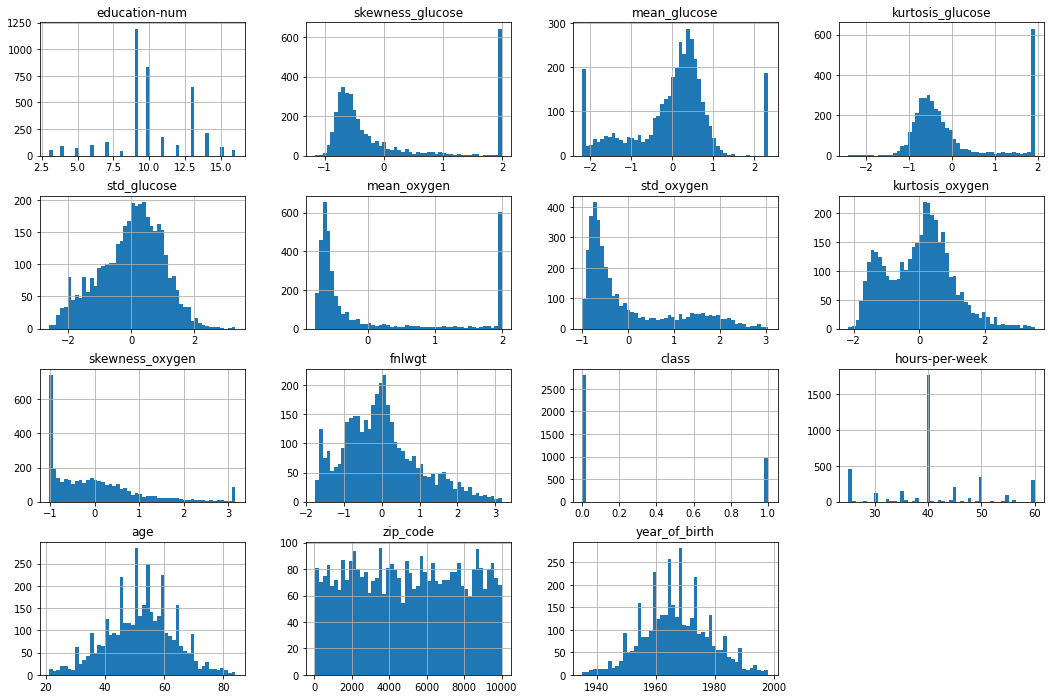

In [23]:
_ = df_train_joined.hist(figsize=(18, 12), bins=50)

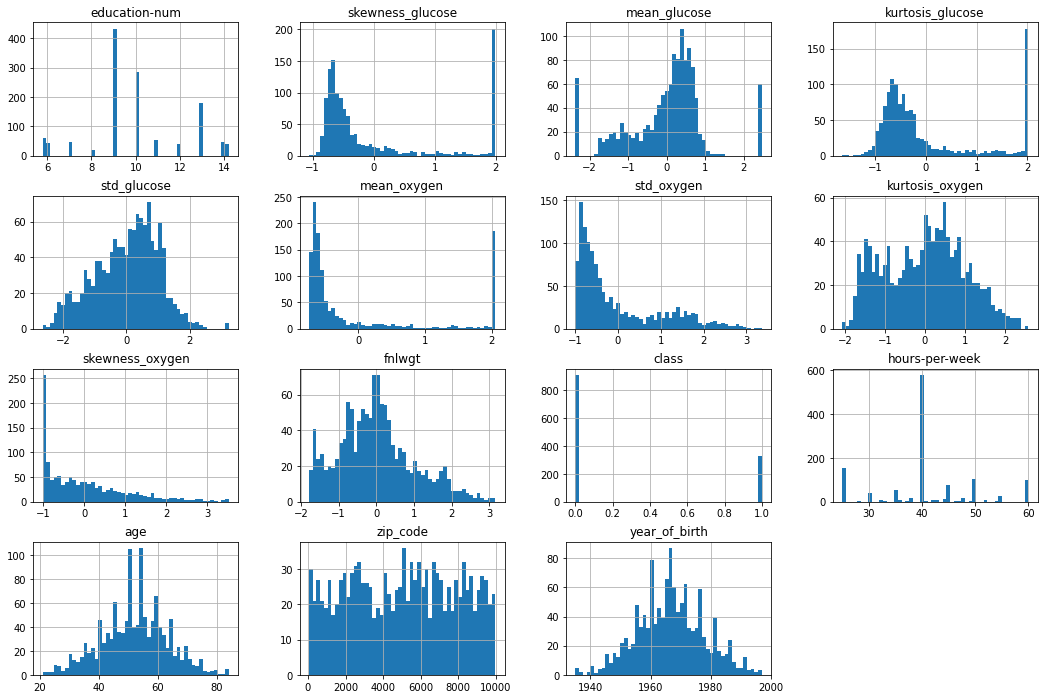

In [24]:
_ = df_valid_joined.hist(figsize=(18, 12), bins=50)

In [25]:
def transform_categoric_to_numeric(dataframe):
    copy_dataframe = dataframe.copy()
    label_encoder = LabelEncoder()
    
    for column_name in copy_dataframe:
        if copy_dataframe[column_name].dtypes == 'object':
            copy_dataframe[column_name] = label_encoder.fit_transform(copy_dataframe[column_name])
            
    return copy_dataframe

df_train_for_ML = transform_categoric_to_numeric(df_train_joined)
df_valid_for_ML = transform_categoric_to_numeric(df_valid_joined)

In [26]:
df_train_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,education,class,income,native-country,hours-per-week,workclass,age,sex,zip_code,year_of_birth
0,David Hayes,Black,Married-civ-spouse,Prof-specialty,False,5.0,Not-in-family,-0.715395,0.876942,-1.075845,...,9th,0.0,<=50K,United-States,40.0,Private,45.0,Female,1952.0,1974.0
1,Stanley Benny,White,Married-civ-spouse,Exec-managerial,False,13.0,Husband,1.986737,-1.034475,1.927080,...,Bachelors,1.0,>50K,United-States,40.0,Private,42.0,Male,2201.0,1977.0
2,Domingo Labriola,Asian-Pac-Islander,Married-civ-spouse,Farming-fishing,False,3.0,Husband,1.986737,2.342372,1.927080,...,5th-6th,1.0,<=50K,Philippines,40.0,Private,46.0,Male,4180.0,1973.0
3,Ronnie Moore,White,Never-married,Other-service,False,10.0,Not-in-family,-0.680963,0.192071,-0.220707,...,Some-college,0.0,<=50K,United-States,40.0,Private,53.0,Male,3273.0,1966.0
4,Victor Mcjunkin,White,Married-civ-spouse,Adm-clerical,False,10.0,Not-in-family,-0.760478,0.802611,-0.824727,...,Some-college,0.0,<=50K,United-States,40.0,Private,52.0,Female,7107.0,1967.0


## Spracovanie prebehlo v poriadku

# Trénovanie stromu

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

features = ['occupation', 'education-num']
labels = ['income']

X = df_train_for_ML[['occupation', 'education-num']]
y = df_train_for_ML['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.7716049382716049
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       871
           1       0.51      0.27      0.35       263

    accuracy                           0.77      1134
   macro avg       0.66      0.60      0.61      1134
weighted avg       0.74      0.77      0.74      1134



In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       871
           1       0.51      0.27      0.35       263

    accuracy                           0.77      1134
   macro avg       0.66      0.60      0.61      1134
weighted avg       0.74      0.77      0.74      1134



In [31]:
print(precision_recall_curve(y_test, y_pred))

(array([0.2319224 , 0.51449275, 1.        ]), array([1.        , 0.26996198, 0.        ]), array([0, 1]))


Export tree as image

In [28]:
# dotfile = StringIO()
# tree.export_graphviz(
#     trained_model,  
#     out_file        = dotfile,
#     feature_names   = x_columns, 
#     class_names     = ['[y=0]', '[y=1]'], # Ascending numerical order
#     filled          = True,
#     rounded         = True
# )
# (graph,) = pydot.graph_from_dot_data(dotfile.getvalue())
# graph.write_png("tree.png")

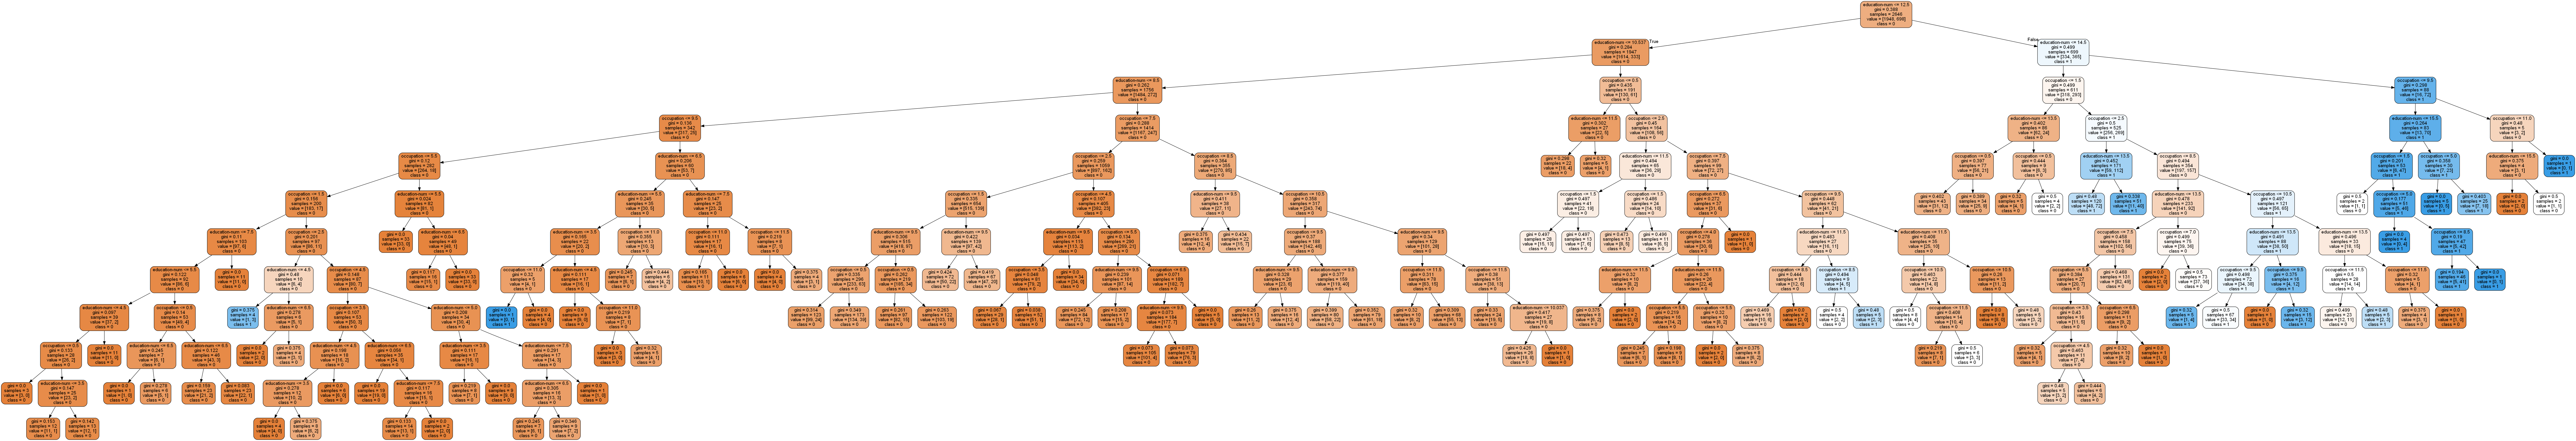

In [38]:
from IPython.display import Image
from six import StringIO
from sklearn import tree
import pydotplus
import pydot

out_file = tree.export_graphviz(clf,
               filled=True, rounded=True,
               feature_names= features,
               class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())

<class 'pandas.core.frame.DataFrame'>
